# Goals
1. Get alpaca viz to work
2. How does alpaca with sinuosid train? Write 5 bullet point summary. 
3. Add nominal dynamics model to alpaca.

# Next
1. Send to James
2. Evaluate performance relative to normal alpaca trainign

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
from main.maml_agent import MAMLAgent, register_flags
register_flags()
from main.alpaca import *
from main.dataset import *
from main.dataViz import *
import yaml

WARN: Cannot define MaxPoolGrad, likely already defined for this version of tensorflow: "Registering two gradient with name 'MaxPoolGrad'! (Previous registration was in register /home/somrita/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/registry.py:66)"


In [4]:
cfg_filename = 'configs/sinusoid-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

In [5]:
dataset = SinusoidDataset(config)

# Agent without meta training, no nominal model

In [254]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_nometa = ALPaCA(config,sess2,g2)
agent_nometa.config['data_horizon'] = 0
agent_nometa.construct_model()
agent_nometa.train(dataset, 3000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 32)
context phi shape  (?, ?, 32)
K shape  (?, 32, 1)
loss: 7.4584084
K shape  (?, 32, 1)
loss: 1.8920523
K shape  (?, 32, 1)
loss: 2.7837098
K shape  (?, 32, 1)
loss: 2.1397707
K shape  (?, 32, 1)
loss: 2.0181353
K shape  (?, 32, 1)
loss: 2.3151367
K shape  (?, 32, 1)
loss: 2.543792
K shape  (?, 32, 1)
loss: 2.198007
K shape  (?, 32, 1)
loss: 2.1233807
K shape  (?, 32, 1)
loss: 2.46139
K shape  (?, 32, 1)
loss: 2.695127
K shape  (?, 32, 1)
loss: 2.0682077
K shape  (?, 32, 1)
loss: 2.005696
K shape  (?, 32, 1)
loss: 2.653888
K shape  (?, 32, 1)
loss: 1.9831282
K shape  (?, 32, 1)
loss: 2.2301362
K shape  (?, 32, 1)
loss: 2.083239
K shape  (?, 32, 1)
loss: 2.5445995
K shape  (?, 32, 1)
loss: 2.1787772
K shape  (?, 32, 1)
loss: 1.7541461
K shape  (?, 32, 1)
loss: 2.2917109
K shape  (?, 32, 1)
loss: 2.1595798
K shape  (?, 32, 1)
loss: 2.7515848
K shap

# Agent without meta training, with nominal model

In [255]:
def f_nominal(x):
    return tf.concat([tf.math.sin(x),tf.math.cos(x)], axis = -1)
    # return tf.math.sin(x)

In [256]:
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent_nominal = ALPaCA(config,sess3,g3, preprocess=None, f_nom=f_nominal)
agent_nominal.config['data_horizon'] = 0
agent_nominal.construct_model()
agent_nominal.train(dataset, 3000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

shape of self.context_phi  Tensor("phi_1/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_cx  Tensor("concat:0", shape=(?, ?, 2), dtype=float32)
shape of self.context_phi_aug  Tensor("concat_2:0", shape=(?, ?, 34), dtype=float32)
shape of self.phi  Tensor("phi/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_x  Tensor("concat_1:0", shape=(?, ?, 2), dtype=float32)
shape of self.phi_aug  Tensor("concat_3:0", shape=(?, ?, 34), dtype=float32)
x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 34)
context phi shape  (?, ?, 34)
K shape  (?, 34, 1)
loss: 3.3023126
K shape  (?, 34, 1)
loss: 3.035412
K shape  (?, 34, 1)
loss: 2.636897
K shape  (?, 34, 1)
loss: 2.738288
K shape  (?, 34, 1)
loss: 2.1845443
K shape  (?, 34, 1)
loss: 1.9368026
K shape  (?, 34, 1)
loss: 1.9585327
K shape  (?, 34, 1)
loss: 1.9063946


# Visualize all agents

In [252]:
N_test = 500
test_horz = 30
X_test, Y_test, freq_list_test, amp_list_test, phase_list_test = dataset.sample(N_test,test_horz, return_lists=True)

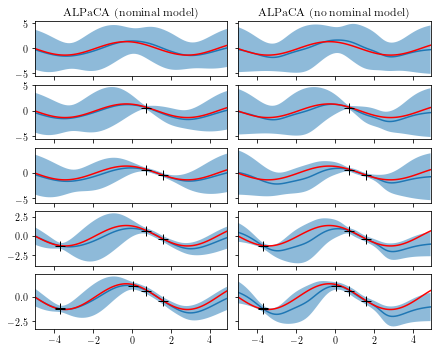

In [253]:
ind = 10
sample_size_list = [0,1,2,3,5]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update = X_test[ind:(ind+1),:num_pts,:]
    Y_update = Y_test[ind:(ind+1),:num_pts,:]
    
    title=None
    legend=False
    if i == 0:
        legend=True
        title=True
        
    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_sin_fig(agent_nominal, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    if i == 0:
        plt.title('ALPaCA (nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_sin_fig(agent_nometa, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)
    if i == 0:
        plt.title('ALPaCA (no nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)
    
#     ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
#     gen_sin_fig(GPR_agent, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
#     plt.setp(ax3.get_yticklabels(), visible=False)
#     if i == 0:
#         plt.title('GPR')
#     if i < len(sample_size_list) - 1:
#         plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/sinusoid_three.pdf')
plt.show()

# Predict fixed phase, freq sinusoids

In [257]:
cfg_filename = 'configs/sinusoid-varyamp-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

In [258]:
dataset = SinusoidDataset(config)

# Agent without meta training, with nominal model

In [259]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_nometa = ALPaCA(config,sess2,g2)
agent_nometa.config['data_horizon'] = 0
agent_nometa.construct_model()
agent_nometa.train(dataset, 3000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 32)
context phi shape  (?, ?, 32)
K shape  (?, 32, 1)
loss: 7.4444
K shape  (?, 32, 1)
loss: 2.0550692
K shape  (?, 32, 1)
loss: 1.95829
K shape  (?, 32, 1)
loss: 1.4019519
K shape  (?, 32, 1)
loss: 1.1437675
K shape  (?, 32, 1)
loss: 0.9291403
K shape  (?, 32, 1)
loss: 0.56787676
K shape  (?, 32, 1)
loss: 1.4027817
K shape  (?, 32, 1)
loss: 0.455274
K shape  (?, 32, 1)
loss: 1.23887
K shape  (?, 32, 1)
loss: 1.1535897
K shape  (?, 32, 1)
loss: 0.49584892
K shape  (?, 32, 1)
loss: 0.8523556
K shape  (?, 32, 1)
loss: 0.98209333
K shape  (?, 32, 1)
loss: 0.5403952
K shape  (?, 32, 1)
loss: 0.7194882
K shape  (?, 32, 1)
loss: 1.4793985
K shape  (?, 32, 1)
loss: 0.29315352
K shape  (?, 32, 1)
loss: 0.93517816
K shape  (?, 32, 1)
loss: 0.30245656
K shape  (?, 32, 1)
loss: 0.3336946
K shape  (?, 32, 1)
loss: 0.3584522
K shape  (?, 32, 1)
loss: 0.7973173


# Agent without meta training, with nominal model

In [261]:
def f_nominal(x):
    return tf.concat([tf.math.sin(x),tf.math.cos(x)], axis = -1)
    # return tf.math.sin(x)

In [262]:
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent_nominal = ALPaCA(config,sess3,g3, preprocess=None, f_nom=f_nominal)
agent_nominal.config['data_horizon'] = 0
agent_nominal.construct_model()
agent_nominal.train(dataset, 3000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

shape of self.context_phi  Tensor("phi_1/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_cx  Tensor("concat:0", shape=(?, ?, 2), dtype=float32)
shape of self.context_phi_aug  Tensor("concat_2:0", shape=(?, ?, 34), dtype=float32)
shape of self.phi  Tensor("phi/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_x  Tensor("concat_1:0", shape=(?, ?, 2), dtype=float32)
shape of self.phi_aug  Tensor("concat_3:0", shape=(?, ?, 34), dtype=float32)
x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 34)
context phi shape  (?, ?, 34)
K shape  (?, 34, 1)
loss: 3.1126633
K shape  (?, 34, 1)
loss: 1.294081
K shape  (?, 34, 1)
loss: 0.41414422
K shape  (?, 34, 1)
loss: 0.719407
K shape  (?, 34, 1)
loss: 0.6505026
K shape  (?, 34, 1)
loss: 0.75258744
K shape  (?, 34, 1)
loss: 0.94715273
K shape  (?, 34, 1)
loss: 0.7020

# Visualize all agents

In [263]:
N_test = 500
test_horz = 30
X_test, Y_test, freq_list_test, amp_list_test, phase_list_test = dataset.sample(N_test,test_horz, return_lists=True)

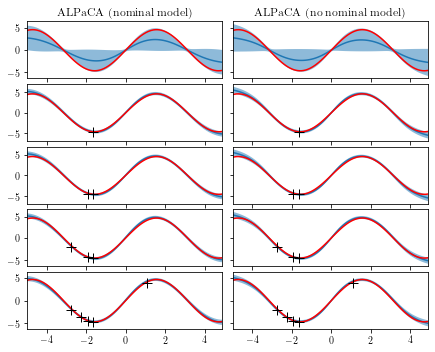

In [264]:
ind = 10
sample_size_list = [0,1,2,3,5]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update = X_test[ind:(ind+1),:num_pts,:]
    Y_update = Y_test[ind:(ind+1),:num_pts,:]
    
    title=None
    legend=False
    if i == 0:
        legend=True
        title=True
        
    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_sin_fig(agent_nominal, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    if i == 0:
        plt.title('ALPaCA (nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_sin_fig(agent_nometa, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)
    if i == 0:
        plt.title('ALPaCA (no nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)
    
#     ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
#     gen_sin_fig(GPR_agent, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
#     plt.setp(ax3.get_yticklabels(), visible=False)
#     if i == 0:
#         plt.title('GPR')
#     if i < len(sample_size_list) - 1:
#         plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/sinusoid_three.pdf')
plt.show()

In [265]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_nometa = ALPaCA(config,sess2,g2)
agent_nometa.config['data_horizon'] = 0
agent_nometa.construct_model()
agent_nometa.train(dataset, 2)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 32)
context phi shape  (?, ?, 32)
K shape  (?, 32, 1)
loss: 7.646643
K shape  (?, 32, 1)


In [266]:
def f_nominal(x):
    return tf.concat([tf.math.sin(x),tf.math.cos(x)], axis = -1)
    # return tf.math.sin(x)
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent_nominal = ALPaCA(config,sess3,g3, preprocess=None, f_nom=f_nominal)
agent_nominal.config['data_horizon'] = 0
agent_nominal.construct_model()
agent_nominal.train(dataset, 2)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

shape of self.context_phi  Tensor("phi_1/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_cx  Tensor("concat:0", shape=(?, ?, 2), dtype=float32)
shape of self.context_phi_aug  Tensor("concat_2:0", shape=(?, ?, 34), dtype=float32)
shape of self.phi  Tensor("phi/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_x  Tensor("concat_1:0", shape=(?, ?, 2), dtype=float32)
shape of self.phi_aug  Tensor("concat_3:0", shape=(?, ?, 34), dtype=float32)
x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 34)
context phi shape  (?, ?, 34)
K shape  (?, 34, 1)
loss: 3.1718707
K shape  (?, 34, 1)


In [267]:
N_test = 500
test_horz = 30
X_test, Y_test, freq_list_test, amp_list_test, phase_list_test = dataset.sample(N_test,test_horz, return_lists=True)

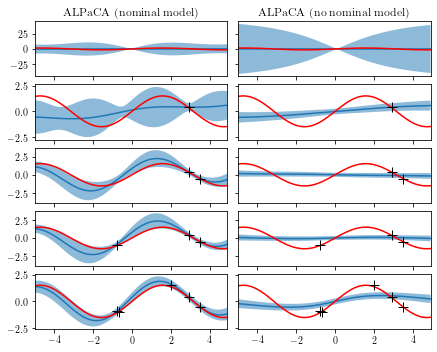

In [268]:
ind = 10
sample_size_list = [0,1,2,3,5]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update = X_test[ind:(ind+1),:num_pts,:]
    Y_update = Y_test[ind:(ind+1),:num_pts,:]
    
    title=None
    legend=False
    if i == 0:
        legend=True
        title=True
        
    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_sin_fig(agent_nominal, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    if i == 0:
        plt.title('ALPaCA (nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_sin_fig(agent_nometa, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)
    if i == 0:
        plt.title('ALPaCA (no nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)
    
#     ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
#     gen_sin_fig(GPR_agent, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
#     plt.setp(ax3.get_yticklabels(), visible=False)
#     if i == 0:
#         plt.title('GPR')
#     if i < len(sample_size_list) - 1:
#         plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/sinusoid_three.pdf')
plt.show()

In [274]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent_nometa = ALPaCA(config,sess2,g2)
agent_nometa.config['data_horizon'] = 0
agent_nometa.construct_model()
agent_nometa.train(dataset, 100)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 32)
context phi shape  (?, ?, 32)
K shape  (?, 32, 1)
loss: 5.2296247
K shape  (?, 32, 1)
loss: 2.0350056
K shape  (?, 32, 1)


In [275]:
def f_nominal(x):
    return tf.concat([tf.math.sin(x),tf.math.cos(x)], axis = -1)
    # return tf.math.sin(x)
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent_nominal = ALPaCA(config,sess3,g3, preprocess=None, f_nom=f_nominal)
agent_nominal.config['data_horizon'] = 0
agent_nominal.construct_model()
agent_nominal.train(dataset, 100)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

shape of self.context_phi  Tensor("phi_1/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_cx  Tensor("concat:0", shape=(?, ?, 2), dtype=float32)
shape of self.context_phi_aug  Tensor("concat_2:0", shape=(?, ?, 34), dtype=float32)
shape of self.phi  Tensor("phi/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
shape of self.f_nom_x  Tensor("concat_1:0", shape=(?, ?, 2), dtype=float32)
shape of self.phi_aug  Tensor("concat_3:0", shape=(?, ?, 34), dtype=float32)
x_dim  1
y_dim  1
phi_dim  32
phi shape  (?, ?, 34)
context phi shape  (?, ?, 34)
K shape  (?, 34, 1)
loss: 6.190205
K shape  (?, 34, 1)
loss: 1.7357514
K shape  (?, 34, 1)


In [276]:
N_test = 500
test_horz = 30
X_test, Y_test, freq_list_test, amp_list_test, phase_list_test = dataset.sample(N_test,test_horz, return_lists=True)

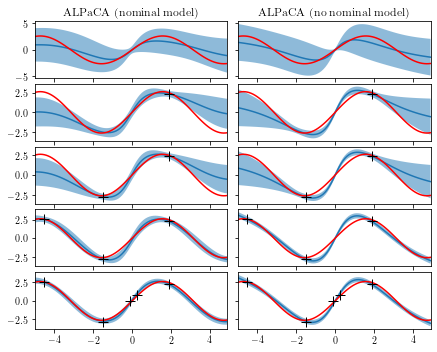

In [277]:
ind = 10
sample_size_list = [0,1,2,3,5]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update = X_test[ind:(ind+1),:num_pts,:]
    Y_update = Y_test[ind:(ind+1),:num_pts,:]
    
    title=None
    legend=False
    if i == 0:
        legend=True
        title=True
        
    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_sin_fig(agent_nominal, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    if i == 0:
        plt.title('ALPaCA (nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)
    
    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_sin_fig(agent_nometa, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)
    if i == 0:
        plt.title('ALPaCA (no nominal model)')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)
    
#     ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
#     gen_sin_fig(GPR_agent, X_update, Y_update, freq_list_test[ind], phase_list_test[ind], amp_list_test[ind], label=None)
#     plt.setp(ax3.get_yticklabels(), visible=False)
#     if i == 0:
#         plt.title('GPR')
#     if i < len(sample_size_list) - 1:
#         plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/sinusoid_three.pdf')
plt.show()